STAT 453: Deep Learning (Spring 2020)
Instructor: Sebastian Raschka (sraschka@wisc.edu)
- Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2020/ 
- GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss20

- Runs on CPU (not recommended here) or GPU (if available)

# ResNet-152 Convolutional Neural Network

## Imports

In [2]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

## Settings and Dataset

In [4]:
##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
NUM_EPOCHS = 50

# Architecture
NUM_FEATURES = 128*128
NUM_CLASSES = 10
BATCH_SIZE = 256
DEVICE = 'cuda:2' # default GPU device
GRAYSCALE = False


##########################
### MNIST DATASET
##########################

# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.CIFAR10(root='data', 
                                 train=True, 
                                 transform=transforms.ToTensor(),
                                 download=True)

test_dataset = datasets.CIFAR10(root='data', 
                                train=False, 
                                transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Files already downloaded and verified
Image batch dimensions: torch.Size([256, 3, 32, 32])
Image label dimensions: torch.Size([256])


## Model

In [5]:
##########################
### MODEL
##########################


##########################
### MODEL
##########################


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out




class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        #self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        #self.fc = nn.Linear(2048 * block.expansion, num_classes)
        self.fc = nn.Linear(2048, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        #x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet152(num_classes, grayscale):
    """Constructs a ResNet-152 model."""
    model = ResNet(block=Bottleneck, 
                   layers=[3, 4, 36, 3],
                   num_classes=NUM_CLASSES,
                   grayscale=grayscale)
    return model



In [6]:
torch.manual_seed(RANDOM_SEED)

##########################
### COST AND OPTIMIZER
##########################

model = resnet152(NUM_CLASSES, GRAYSCALE)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Training

In [7]:
def compute_accuracy(model, data_loader):
    model.eval()
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100


def compute_epoch_loss(model, data_loader):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)
            logits, probas = model(features)
            loss = F.cross_entropy(logits, targets, reduction='sum')
            num_examples += targets.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss
    

    
minibatch_cost, epoch_cost = [], []
all_train_acc, all_test_acc = [], []

start_time = time.time()
for epoch in range(NUM_EPOCHS):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), cost))

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        train_acc = compute_accuracy(model, train_loader)
        test_acc = compute_accuracy(model, test_loader)
        print('Epoch: %03d/%03d | Train: %.3f%% | Test: %.3f%%' % (
              epoch+1, NUM_EPOCHS, train_acc, test_acc))
        
        all_train_acc.append(train_acc)
        all_test_acc.append(test_acc)
        cost = compute_epoch_loss(model, train_loader)
        epoch_cost.append(cost)


    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/050 | Batch 0000/0196 | Cost: 2.4837
Epoch: 001/050 | Batch 0050/0196 | Cost: 2.0271
Epoch: 001/050 | Batch 0100/0196 | Cost: 1.8725
Epoch: 001/050 | Batch 0150/0196 | Cost: 1.6133
Epoch: 001/050 | Train: 43.348% | Test: 41.000%
Time elapsed: 1.13 min
Epoch: 002/050 | Batch 0000/0196 | Cost: 1.4946
Epoch: 002/050 | Batch 0050/0196 | Cost: 1.6658
Epoch: 002/050 | Batch 0100/0196 | Cost: 1.4777
Epoch: 002/050 | Batch 0150/0196 | Cost: 1.6430
Epoch: 002/050 | Train: 45.576% | Test: 42.740%
Time elapsed: 2.29 min
Epoch: 003/050 | Batch 0000/0196 | Cost: 1.4298
Epoch: 003/050 | Batch 0050/0196 | Cost: 1.2600
Epoch: 003/050 | Batch 0100/0196 | Cost: 1.4068
Epoch: 003/050 | Batch 0150/0196 | Cost: 1.2088
Epoch: 003/050 | Train: 33.124% | Test: 33.320%
Time elapsed: 3.50 min
Epoch: 004/050 | Batch 0000/0196 | Cost: 1.7567
Epoch: 004/050 | Batch 0050/0196 | Cost: 1.4059
Epoch: 004/050 | Batch 0100/0196 | Cost: 1.2751
Epoch: 004/050 | Batch 0150/0196 | Cost: 1.3524
Epoch: 004/050 | Tr

## Evaluation

In [8]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 69.59%


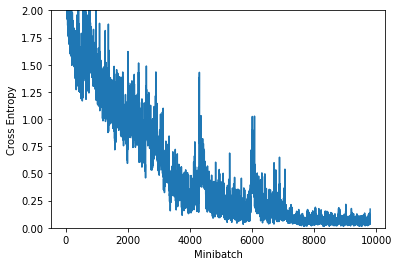

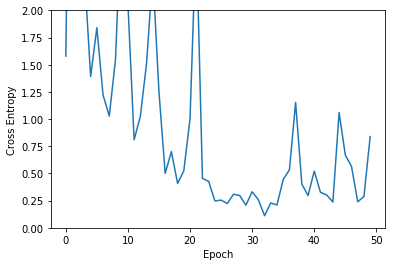

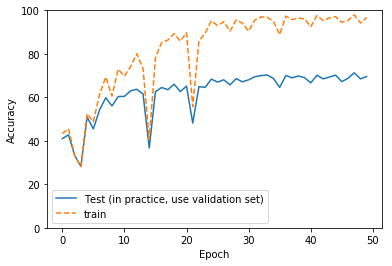

In [9]:
plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.ylim([0, 2])
plt.show()

plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.ylim([0, 2])
plt.show()


plt.plot(range(len(all_test_acc)), all_test_acc, label='Test (in practice, use validation set)')
plt.plot(range(len(all_train_acc)), all_train_acc, linestyle='--', label='train')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0, 100])
plt.legend()
plt.show()